### Geting the models and packages

In [ ]:
!git clone https://github.com/sai-phyo-hein/Hybrid_Transformer_for_Portfolio_Allocation.git
!pip install -q -r /content/Hybrid_Transformer_for_Portfolio_Allocation/requirements.txt

Cloning into 'Hybrid_Transformer_for_Portfolio_Allocation'...
remote: Enumerating objects: 343, done.
remote: Counting objects: 100% (223/223), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 343 (delta 150), reused 197 (delta 134), pack-reused 120
Receiving objects: 100% (343/343), 30.15 MiB | 25.82 MiB/s, done.
Resolving deltas: 100% (197/197), done.
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.4/983.4 kB 10.3 MB/s eta 0:00:00


In [ ]:
from Hybrid_Transformer_for_Portfolio_Allocation.data.eq_data_loader import get_eq_data
from Hybrid_Transformer_for_Portfolio_Allocation.data.data_prep_hybrid import hybrid_transformer_database
from Hybrid_Transformer_for_Portfolio_Allocation.data.data_prep_vanilla import vanilla_transformer_database
from Hybrid_Transformer_for_Portfolio_Allocation.models.benchmark_transformer_model import Transformer_Portfolio

import pandas as pd
import numpy as np
import tensorflow as tf
import json

In [ ]:
data_config = json.load(open('/content/Hybrid_Transformer_for_Portfolio_Allocation/configs/data_config.json', 'r'))

### Getting Data

In [ ]:
data = get_eq_data(
    '/content/Hybrid_Transformer_for_Portfolio_Allocation/data/nifty_50_metadata.csv',
    start = data_config['data_start_date'],
    end = data_config['data_end_date'],
    corr_thresh = data_config['correlation_thresh'],
    market_cap_filter = data_config['market_cap_filter']
)

[*********************100%%**********************]  50 of 50 completed


In [ ]:
xtrain, xtest, ytrain, ytest, train_index, test_index = vanilla_transformer_database(data = data, timestep = 16, lag = 1, lagSD = 10, test_size= 0.2, purge_size = 30)
print(xtrain.shape, xtest.shape, ytrain.shape, ytest.shape)

(1970, 16, 34) (500, 16, 34) (1970, 17) (500, 17)


In [ ]:
tf.keras.backend.clear_session()

### Grid Search Validation

In [ ]:
cv_sharpe_thresh = 0.19
current_sharpe = 0

In [ ]:
from sklearn.model_selection import train_test_split
attention_numbers = [17, 34]
learning_rates = [0.01, 0.001, 0.0001]
batch_sizes = [8, 64, 128, 256]
dropouts = [0.05, 0.1]

trainx_, valx, trainy_, valy = train_test_split(xtrain.numpy(), ytrain.numpy(), test_size = 0.2, shuffle = False)

model_performance = pd.DataFrame()

In [ ]:
for an in attention_numbers:
    for lr in learning_rates:
        for bs in batch_sizes:
            for dp in dropouts:

                trainx = tf.convert_to_tensor(trainx_[:int(trainx_.shape[0] / bs) * bs, :, :], np.float32)
                trainy = tf.convert_to_tensor(trainy_[:trainx.shape[0], :], np.float32)
                val_price = tf.convert_to_tensor(data.loc[train_index, :].iloc[:trainx.shape[0], :].pct_change().dropna().values, np.float32)

                model = Transformer_Portfolio(trainx.shape[1], trainx.shape[2], outputShape = trainy.shape[1],  headsAttention = an, dropout= dp, learningRate = lr)
                model.allocation_vanilla_train(trainx, trainy, Epochs = 5, BatchSize = bs)

                eval_price = data.iloc[:xtrain.shape[0], :].iloc[-valx.shape[0] + 10:, :]
                eval_weights = model.allocation_vanilla_test(valx[10:, :])
                eval_mean = (eval_price.pct_change().dropna() * eval_weights[:-1, :]).sum(axis = 1).mean()
                eval_std = (eval_price.pct_change().dropna() * eval_weights[:-1, :]).sum(axis = 1).std()
                eval_sharpe = eval_mean / eval_std

                if eval_sharpe > cv_sharpe_thresh:
                    model.vanilla_save_weights('best_weights.h5')
                if eval_sharpe > current_sharpe:
                    current_sharpe = eval_sharpe
                    model.vanilla_save_weights('current_best.h5')

                tf.keras.backend.clear_session()

                temp_performance = pd.DataFrame()
                temp_performance['attention_num'] = [an]
                temp_performance['learning_rate'] = [lr]
                temp_performance['batch_size'] = [bs]
                temp_performance['dropout'] = [dp]
                temp_performance['eval_sharpe_ratio'] = [eval_sharpe]

                model_performance = pd.concat([model_performance, temp_performance])

12/12 [==============================] - 0s 6ms/step


In [ ]:
model_performance.sort_values('eval_sharpe_ratio', ascending = False).head()

,attention_num,learning_rate,batch_size,dropout,eval_sharpe_ratio
0,34,0.010,128,0.05,0.171807
0,17,0.001,8,0.05,0.171113
0,34,0.010,128,0.10,0.170273
0,34,0.001,256,0.10,0.164550
0,34,0.001,256,0.05,0.164076


In [ ]:
tf.keras.backend.clear_session()

In [ ]:
Dropout = 0.05
LearningRate = 0.01
Epochs = 100
BatchSize = 8
num_heads = 34

trainx = tf.convert_to_tensor(trainx_[:int(trainx_.shape[0] / BatchSize) * BatchSize, :, :], np.float32)
trainy = tf.convert_to_tensor(trainy_[:trainx.shape[0], :], np.float32)

model = Transformer_Portfolio(trainx.shape[1], trainx.shape[2], outputShape = trainy.shape[1],  headsAttention = num_heads, dropout= Dropout, learningRate = LearningRate)
model.vanilla_load_weights('current_best.h5')
model.allocation_vanilla_train(trainx, trainy, Epochs = Epochs, BatchSize = BatchSize)

In [ ]:
eval_price = data.iloc[:xtrain.shape[0], :].iloc[-valx.shape[0]+10:, :]
eval_weights = model.allocation_vanilla_test(valx[10:, :])
eval_mean = (eval_price * eval_weights).sum(axis = 1).pct_change().dropna().mean()
eval_std = (eval_price * eval_weights).sum(axis = 1).pct_change().dropna().std()
eval_sharpe = eval_mean / eval_std

12/12 [==============================] - 0s 7ms/step


In [ ]:
eval_mean, eval_std, eval_sharpe

(0.001474335292035802, 0.010130075103673317, 0.14554041080121766)

### Test on Test Set

In [ ]:
test_weights = model.allocation_vanilla_test(xtest)

16/16 [==============================] - 0s 7ms/step


In [ ]:
test_mean = ((data.loc[test_index, :].pct_change().dropna() * test_weights[:-1, :].round(3)).sum(axis = 1) - 0.01 * (test_weights[1:, :] - test_weights[:-1, :]).sum(axis = 1)).mean()
test_mean

0.0005324320767760741

In [ ]:
test_std = ((data.loc[test_index, :].pct_change().dropna() * test_weights[:-1, :].round(3)).sum(axis = 1) - 0.01 * (test_weights[1:, :] - test_weights[:-1, :]).sum(axis = 1)).std()
test_std

0.008062692436702422

In [ ]:
test_sharpe = test_mean / test_std

In [ ]:
test_sharpe

0.06603651087475124

In [ ]:
eq_w_mean = (data.loc[test_index, :].iloc[1:, :] * np.ones(test_weights.shape)[:-1, :] * 10000 / 17).sum(axis = 1).pct_change().dropna().mean()
eq_w_std = (data.loc[test_index, :].iloc[1:, :] * np.ones(test_weights.shape)[:-1, :] * 10000 / 17).sum(axis = 1).pct_change().dropna().std()

In [ ]:
eq_w_mean / eq_w_std

0.09016788645565059

In [ ]:
test_mean, eq_w_mean

(0.0005324320767760741, 0.0007130023896805516)

In [ ]:
test_std, eq_w_std

(0.008062692436702422, 0.007907498087262415)

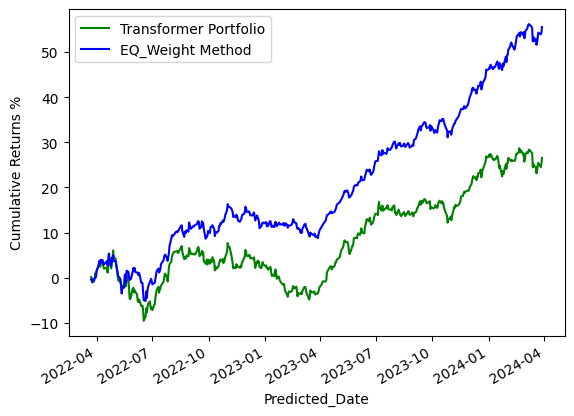

In [ ]:
import matplotlib.pyplot as plt
((data.loc[test_index, :].pct_change().dropna() * test_weights[:-1, :]).sum(axis = 1).cumsum()  * 100).plot(color = 'green')
((data.loc[test_index, :].pct_change().dropna() * np.ones(test_weights[:-1, :].shape) * 1 / 17).sum(axis = 1).cumsum() * 100).plot(color = 'blue',)
plt.legend(['Transformer Portfolio', 'EQ_Weight Method'])
plt.xlabel('Predicted_Date')
plt.ylabel('Cumulative Returns %')
plt.show()

In [ ]:
model.vanilla_save_weights('vanilla_model_trained_weights.h5')